In [1]:
import heapq
import networkx as nx
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import cvxpy as cp
import xpress
from itertools import combinations
from tqdm import tqdm
xpress.init('/Users/finnmacken/opt/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr')

Using the Community license in this session. If you have a full Xpress license, pass the full path to your license file to xpress.init(). If you want to use the FICO Community license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Users/finnmacken/opt/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr')


## Scheduler

In [2]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        if len(self.priority_queue) != 0:
            return self.priority_queue[0].timestamp
        else:
            return 0

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__} \n')


## Network Generation

In [3]:
class Truck:
    def __init__(self, id):
        self.id = id
        self.node_position = None

        # waste
        self.max_waste = 10 # tons
        self.waste_capacity = self.max_waste
        self.dumping_time = 15
        self.loading_time = 45
        self.waste_record = [self.max_waste]

        # fuel
        self.max_fuel = 200 # liters
        self.fuel = self.max_fuel
        self.fuel_efficiency = 0.78 # liters/kilometer
        self.refueling_time = 20 # mins
        self.fuel_record = [self.max_fuel]
        
        # metrics
        self.total_fuel_expended = 0
        self.total_waste_collected = 0
        self.finished_time = 0
        
        self.refuel_trips = 0
        self.dump_trips = 0
        

In [4]:
class WasteRoadNetwork:
    def __init__(self, num_trucks=3, fleet_algorithm='greedy', network_type='yarra'):
        self.network_type = network_type
        self.fleet_algorithm = fleet_algorithm
        self.num_trucks = num_trucks
        self.speed_limit = 30 # km/h
        self.remaining_waste = []
    
    def generate_random_network(self):
        self.network = nx.gnm_random_graph(20, 24)

        while not nx.is_connected(self.network) or len(nx.periphery(self.network)) < 4:
            self.network = nx.gnm_random_graph(20, 24)
        
        # setting initial layout
        self.network.pos = nx.spring_layout(self.network)

        # setting node types
        for node in self.network.nodes:
            self.network.nodes[node]['node_type'] = 'intersection'
        
        location_list = random.sample(nx.periphery(self.network), len(nx.periphery(self.network)))

        self.network.nodes[location_list[0]]['node_type'] = 'office'
        self.network.nodes[location_list[1]]['node_type'] = 'dump'

        # set winery locations and waste
        for i in location_list[2:]:
            self.network.nodes[i]['node_type'] = 'winery'
            self.network.nodes[i]['waste'] = sts.norm(loc=400, scale=20).rvs(1)[0]
        
        # set metadata about important locations
        self.office_location, self.dump_location = location_list[0], location_list[1]
        self.winery_locations = location_list[2:]

        # setting edge weights
        weight_dict = dict(zip(nx.edges(self.network), sts.norm.rvs(loc=100, scale=10,
                                                            size=len(nx.edges(self.network))))  )
        nx.set_edge_attributes(self.network, values = weight_dict, name = 'weight')

    def generate_truncnorm_sample(self, loc, scale):
        s = sts.norm(loc=loc, scale=scale).rvs(1)[0]
        while s < 0:
            s = sts.norm(loc=loc, scale=scale).rvs(1)[0]
        return s

    def generate_yarra_valley_network(self):
        edge_list = [ 
            (14, 2, 0.55), (2, 3, 0.40), (3, 4, 3.78), (2, 5, 1.74), (5, 9, 0.137),
            (9, 10, 1.22), (5, 10, 1.24), (10, 11, 2.02), (5, 6, 0.98), (6, 7, 0.28),
            (6, 8, 1.62), (11, 13, 1.79), (13, 1, 0.84), (1, 15, 1.05), (1, 16, 2.80),
            (11, 12, 2.03), (12, 17, 0.34), (13, 17, 0.54), (17, 18, 0.91), (18, 20, 1.65),
            (18, 19, 3.26), 
            #####
            (7, 12, 5.1), (16, 15, 0.50), (4, 15, 6.3), (16, 19, 4.3), (20, 19, 2.1), (14, 20, 7),
            (8, 7, 3.7)
            ]

        location_dict = {
            'office': 1,
            'dump': 20,
            'wineries': [(14, "l"), (3, "l"), (4, "s"), (7, "m"), (8, "m"), (9, "l"), (12, 's'), (13, 's'), (15, 'm'), (16, 's'), (19, 'l')]
        }
        self.location_dict = location_dict

        self.network = nx.Graph()

        for e1, e2, w in edge_list:
            self.network.add_edge(e1, e2, weight = w)
        
         # setting initial layout
        self.network.pos = nx.spring_layout(self.network)

        # set metadata about important locations
        self.office_location, self.dump_location = location_dict['office'], location_dict['dump']
        self.winery_locations = [i for (i, size) in location_dict['wineries']]

        # setting initial node types
        for node in self.network.nodes:
            self.network.nodes[node]['node_type'] = 'intersection'

        # set network locations
        self.network.nodes[location_dict['office']]['node_type'] = 'office'
        self.network.nodes[location_dict['dump']]['node_type'] = 'dump'

        # setting winery waste
        self.total_waste = 0
        for idx, cat in location_dict['wineries']:
            self.network.nodes[idx]['node_type'] = 'winery'
            if cat == 's':
                self.network.nodes[idx]['waste'] = self.generate_truncnorm_sample(3.3, 0.33)
            elif cat == 'm':
                self.network.nodes[idx]['waste'] =self.generate_truncnorm_sample(5, 0.5)
            else:
                self.network.nodes[idx]['waste'] = self.generate_truncnorm_sample(8.3, 0.83)
            self.total_waste += self.network.nodes[idx]['waste']
        
    def multiple_tsp_initialize(self):
        def simplify_graph_with_predicate(G: nx.Graph, node_removal_predicate: callable):
            '''
            Loop over the graph until all nodes that match the supplied predicate 
            have been removed and their incident edges fused.
            '''
            g = G.copy()
            while any(node_removal_predicate(data) for node, data in g.nodes(data=True)):

                g0 = g.copy()

                for node, data in g.nodes(data=True):
                    if node_removal_predicate(data):
                        edges_containing_node = g.edges(node)
                        dst_to_link = [e[1] for e in edges_containing_node]
                        dst_pairs_to_link = list(combinations(dst_to_link, r = 2))
                        for pair in dst_pairs_to_link:
                           dist = nx.shortest_path_length(g0, pair[0], pair[1], weight='weight')
                           g0.add_edge(pair[0], pair[1], weight=dist)  
                        g0.remove_node(node)
                        break
                g = g0
            return g

        # tsp_graph = simplify_graph_with_predicate(self.network, 
        #                                          lambda x: x['node_type'] == 'intersection')

        def generate_tsp_path(network):
            C = np.zeros((len(self.network.nodes), len(self.network.nodes)))
            for node, data in self.network.nodes(data=True):
                for neighbor in list(self.network.neighbors(node)):
                    C[node-1][neighbor-1] = self.network[node][neighbor]['weight']
            
            # wineries = [node for node, data in roads.network.nodes(data=True) if data['node_type'] == 'winery']
            C[np.where(C == 0)] = 100_000
            np.fill_diagonal(C, 0)
            n = len(network.nodes)

            C = C.astype(int)

            # Defining the variables
            X = cp.Variable(C.shape, boolean=True)
            u = cp.Variable(n, integer=True)
            m = len(self.trucks)
            ones = np.ones((n,1))

            # Defining the objective function
            objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

            # Defining the constraints
            constraints = []
            constraints += [X[0,:] @ ones == m]
            constraints += [X[:,0] @ ones == m]
            constraints += [X[1:,:] @ ones == 1]
            constraints += [X[:,1:].T @ ones == 1]
            constraints += [cp.diag(X) == 0]
            constraints += [u[1:] >= 2]
            constraints += [u[1:] <= n]
            constraints += [u[0] == 1]

            for i in range(1, n):
                for j in range(1, n):
                    if i != j:
                        constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

            # Solving the problem
            prob = cp.Problem(objective, constraints)
            prob.solve(verbose=False, solver='XPRESS')

            # Transforming the solution to paths
            X_sol = np.argwhere(X.value==1)
            ruta = {}
            for i in range(0, m):
                ruta['Salesman_' + str(i+1)] = [0]
                j = i
                a = 10e10
                while a != 0:
                    a = X_sol[j,1]
                    ruta['Salesman_' + str(i+1)].append(a)
                    j = np.where(X_sol[:,0] == a)
                    j = j[0][0]
                    a = j

            for i in ruta.keys():
                ruta[i] = [i+1 for i in ruta[i]]
            return list(ruta.values())
           
        truck_paths = generate_tsp_path(self.network)
        for idx in range(len(self.trucks)):
            self.trucks[idx].collection_schedule = [i for i in truck_paths[idx] if i in self.winery_locations]

    def initialize(self):
        self.trucks = [Truck(i) for i in range(self.num_trucks)]

        # generate network
        {'random': self.generate_random_network(),
         'yarra': self.generate_yarra_valley_network()}[self.network_type]
        
        # create label dictionary for printing
        winery_dict = {key: 'a winery' for key in self.winery_locations}
        self.label_dict = (winery_dict | {
            self.office_location: 'the office',
            self.dump_location: 'the waste dump',
        })

         # set truck initial positions
        for truck in self.trucks:
            truck.node_position = self.office_location

        self.fleet_algorithm == "multiple_tsp" and self.multiple_tsp_initialize()
    
    def can_refuel(self, truck, target_position):
        # generate total path in ilmeters
        total_distance = (nx.shortest_path_length(self.network, truck.node_position, target_position, weight='weight') +
                      nx.shortest_path_length(self.network, target_position, self.office_location, weight='weight')
                     )
        fuel_consumed = total_distance * truck.fuel_efficiency
        return truck.fuel >= fuel_consumed
    
    def drive(self, truck, target_position):
        # calculate time required and move truck to new location
        distance = nx.shortest_path_length(self.network, truck.node_position, target_position, weight='weight') # kms
    
        elapsed_time = (distance / self.speed_limit) * 60 # in mins
        consumed_fuel = distance * truck.fuel_efficiency # in liters

        truck.node_position = target_position
        truck.fuel -= consumed_fuel
        truck.total_fuel_expended += consumed_fuel

        truck.fuel_record.append(truck.fuel)
        return elapsed_time
        
    def print_update(self, schedule, truck, node, event_duration, additional_text = ""):
        winery_text = f"[Remaining Winery Waste After Collection: {round(self.network.nodes[node]['waste'], 2)}]" if self.label_dict[node] == 'a winery' else ""

        print(f"Truck {truck.id} is heading to {self.label_dict[node]} (node {node}) {additional_text}." 
                + winery_text
                + f" \n After performing its task there, its waste capacity will be {truck.waste_capacity} and fuel will be {truck.fuel}."
                + f"\n It's currently {round(schedule.now, 3)} mins since the start and the truck will arrive at {round(schedule.now + event_duration, 3)} mins \n")

    def random_update(self, schedule, truck, print_simulation):
        # if the truck has no waste capacity
        if truck.waste_capacity == 0:
            if self.can_refuel(truck, self.dump_location):
                # drive to dump, remove waste, add new event
                self.dump_waste(truck, schedule, print_simulation)
            else:
                # drive to refuel location, refuel, add new event
                self.refuel(truck, schedule, print_simulation, add_new_event=True)

        # if the truck has waste capacity
        else:
            # randomly select a winery with remaining waste
            winery_idx = (random.choice([winery for winery in self.winery_locations
                                                if self.network.nodes[winery]['waste'] > 0]) 
                                    if len([winery for winery in self.winery_locations if self.network.nodes[winery]['waste'] > 0])
                                    else None
                         )
            if winery_idx != None:            
                # check whether the truck has enough fuel to drive there
                if self.can_refuel(truck, winery_idx):
                    self.load_waste(truck, schedule, winery_idx, print_simulation)
                    return
            else:
                if truck.waste_capacity != truck.max_waste and self.can_refuel(truck, self.dump_location):
                    self.dump_waste(truck, schedule, print_simulation)
                else:
                    # drive to refuel location, refuel
                    self.refuel(truck, schedule, print_simulation, add_new_event=False)

    def greedy_update(self, schedule, truck, print_simulation):
        # if the truck has no waste capacity
        if truck.waste_capacity == 0:
            if self.can_refuel(truck, self.dump_location):
                # drive to dump, remove waste, add new event
                self.dump_waste(truck, schedule, print_simulation)
            else:
                # drive to refuel location, refuel, add new event
                self.refuel(truck, schedule, print_simulation, add_new_event=True)

        # if the truck has waste capacity
        else:
            # filter for wineries with waste & sort by distance from truck
            sorted_wineries = sorted([winery for winery in self.winery_locations
                                    if self.network.nodes[winery]['waste'] > 0], 
                                    key=lambda x: nx.shortest_path_length(self.network, 
                                                                truck.node_position, 
                                                                x,  weight='weight'))

            for winery_idx in sorted_wineries:
                # check whether the truck has enough fuel to drive there
                if self.can_refuel(truck, winery_idx):
                    self.load_waste(truck, schedule, winery_idx, print_simulation)
                    return
                
            if truck.waste_capacity != truck.max_waste and self.can_refuel(truck, self.dump_location):
                self.dump_waste(truck, schedule, print_simulation)
            else:
                # drive to refuel location, refuel
                self.refuel(truck, schedule, print_simulation, add_new_event=False)

    def multiple_tsp_update(self, schedule, truck, print_simulation):    
        # update the collection schedule if the active winery has no waste
        if not len(truck.collection_schedule) == 0 and self.network.nodes[truck.collection_schedule[0]]['waste'] == 0:
            truck.collection_schedule = truck.collection_schedule[1:]
        
        if len(truck.collection_schedule) == 0:
            if truck.waste_capacity != truck.max_waste and self.can_refuel(truck, self.dump_location):
                self.dump_waste(truck, schedule, print_simulation)
            else:
                # drive to refuel location, refuel
                self.refuel(truck, schedule, print_simulation, add_new_event=False)
            return

        if truck.waste_capacity == 0:
            if self.can_refuel(truck, self.dump_location):
                # drive to dump, remove waste, add new event
                self.dump_waste(truck, schedule, print_simulation)
            else:
                # drive to refuel location, refuel, add new event
                self.refuel(truck, schedule, print_simulation, add_new_event=True)
        
        else:
            winery_idx = truck.collection_schedule[0]
            if self.can_refuel(truck, winery_idx):
                # load waste from the winery 
                self.load_waste(truck, schedule, winery_idx, print_simulation)
                return
    
    def load_waste(self, truck, schedule, winery_idx, print_simulation):
        elapsed_time = self.drive(truck, winery_idx)
        transferred_waste = min(self.network.nodes[winery_idx]['waste'], truck.waste_capacity)
        truck.waste_capacity, self.network.nodes[winery_idx]['waste'] = (truck.waste_capacity - transferred_waste,
                                                                        self.network.nodes[winery_idx]['waste'] - transferred_waste)
        truck.total_waste_collected += transferred_waste
        truck.waste_record.append(truck.waste_capacity)
        self.remaining_waste.append(np.sum([self.network.nodes[winery]['waste'] for winery in self.winery_locations]))
        print_simulation and self.print_update(schedule, truck, winery_idx, elapsed_time + truck.loading_time)
        schedule.add_event_after(elapsed_time + truck.loading_time, self.update, truck, print_simulation, False)

    def dump_waste(self, truck, schedule, print_simulation):
        elapsed_time = self.drive(truck, self.dump_location)
        truck.waste_capacity = truck.max_waste
        truck.waste_record.append(truck.waste_capacity)
        print_simulation and self.print_update(schedule, truck, self.dump_location, elapsed_time + truck.dumping_time)
        schedule.add_event_after(elapsed_time + truck.dumping_time, self.update, truck, print_simulation, False)
    
    def refuel(self, truck, schedule, print_simulation, add_new_event=True):
        elapsed_time = self.drive(truck, self.office_location)
        truck.fuel = truck.max_fuel
        truck.fuel_record.append(truck.fuel)
        print_simulation and self.print_update(schedule, truck, self.office_location, elapsed_time + truck.refueling_time, additional_text="to refuel" if add_new_event else "because there are no more wineries with waste")
        if add_new_event:
            schedule.add_event_after(elapsed_time + truck.loading_time, self.update, truck, print_simulation, False)
        else:
            truck.finished_time = schedule.now + elapsed_time + truck.refueling_time

    def update(self, schedule, truck, print_simulation, day_end):
        if day_end:
            self.refuel(truck, schedule, print_simulation, add_new_event=True)
        else:
            if self.fleet_algorithm == 'greedy':
                self.greedy_update(schedule, truck, print_simulation)
            elif self.fleet_algorithm == "multiple_tsp":
                self.multiple_tsp_update(schedule, truck, print_simulation)
            elif self.fleet_algorithm == 'random':
                self.random_update(schedule, truck, print_simulation)
            else:
                return 'No fleet algorithm specified'
    
    def day_end(self, schedule, print_simulation):
        print_simulation and print(f"End of Day {self.elapsed_days+1}, all trucks returning to refuelling location \n")
        # if the simulation has not yet concluded
        if (not all([(data.get('waste') == 0) for node, data in self.network.nodes(data=True) if node in self.winery_locations]) 
               or not(all([truck.waste_capacity == truck.max_waste for truck in self.trucks]))
               or not(all(truck.node_position == self.office_location for truck in self.trucks)) 
           ):
            # all trucks return to refueling location
            for truck in self.trucks:
                schedule.add_event_after(0, self.update, truck, print_simulation, True)

            # all wineries generate additional waste
            for idx, cat in self.location_dict['wineries']:
                new_waste = {'s': self.generate_truncnorm_sample(3.3, 0.33),
                             'm': self.generate_truncnorm_sample(5, 0.5),
                             'l': self.generate_truncnorm_sample(8.3, 0.83)}[cat]
                            
                self.network.nodes[idx]['waste'] += new_waste
                self.total_waste += new_waste

            # recalculate the schedule for the travelling salesmen
            self.multiple_tsp_initialize()
            
            # a new day end event is scheduled for the next day
            self.elapsed_days += 1
            schedule.add_event_after(self.day_length, self.day_end, print_simulation)
    
    def viable_graph_topology(self):
        # check that all wineries and waste location can be reached from the office
        for truck in self.trucks:
            for location in self.winery_locations + [self.dump_location]:
                if not self.can_refuel(truck, location):
                    return False
        return True

    def run_simulation(self, print_simulation=False, fleet_algorithm='greedy', network_type='yarra', num_trucks=3, day_length=480):
        self.elapsed_days = 0
        self.fleet_algorithm = fleet_algorithm
        self.network_type = network_type
        self.num_trucks = num_trucks
        self.day_length = day_length
        self.safeguard_exceeded = False
        schedule = Schedule()

        self.initialize()
        print_simulation and self.visualize() 

        # check that all important nodes are reachable from the office
        if not self.viable_graph_topology(): return "Essential nodes are not reachable from the office"

        print_simulation and print("Initial Winery Waste:", {f"Winery {winery}": round(self.network.nodes[winery]['waste'], 2) for winery in self.winery_locations})
        print_simulation and print("Initial Truck Capacities:", {f"truck {truck.id}": truck.waste_capacity for truck in self.trucks}, "\n")

        # add initial events for all trucks
        for truck in self.trucks:
            schedule.add_event_after(0, self.update, truck, print_simulation, False)

        # set day event
        schedule.add_event_after(self.day_length, self.day_end, print_simulation)

        # all wineries must have no waste, all trucks must have no waste, and all trucks must be at the office
        its = 0
        while (not all([(data.get('waste') == 0) for node, data in self.network.nodes(data=True) if node in self.winery_locations]) 
               or not(all([truck.waste_capacity == truck.max_waste for truck in self.trucks]))
               or not(all(truck.node_position == self.office_location for truck in self.trucks)) 
               ):
            its += 1
            schedule.run_next_event()
            if schedule.now > self.day_length*7:
                self.safeguard_exceeded = True
                break   
 
        # generate metric summaries
        sim_fuel_use = [truck.total_fuel_expended for truck in self.trucks]
        sim_waste_collected = [truck.total_waste_collected for truck in self.trucks]
        truck_finished_time = [truck.finished_time for truck in self.trucks]
        finished_time = max(self.trucks, key=lambda x: x.finished_time).finished_time 


        return (sim_fuel_use, sim_waste_collected, truck_finished_time, finished_time)
        
    def visualize(self):
        color_map = {"office" :'red',  "dump": "orange", 'intersection':'lightblue', 'winery':'green'}
        nx.draw(self.network, pos=self.network.pos, with_labels=True,
                node_color=[color_map[self.network.nodes[i]['node_type']] for i in self.network.nodes],
                edgecolors=['black' if node not in [truck.node_position for truck in self.trucks]  
                                    else 'yellow' for node, data in self.network.nodes(data=True)],
                linewidths=[1.0 if node not in [truck.node_position for truck in self.trucks]  
                                    else 3.0 for node, data in self.network.nodes(data=True)]
        )
        plt.title("Road Network")
        plt.show()
        


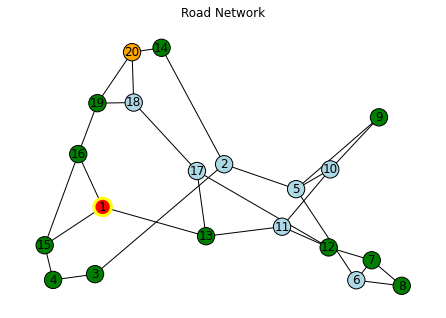

Initial Winery Waste: {'Winery 14': 5.54, 'Winery 3': 8.84, 'Winery 4': 3.3, 'Winery 7': 5.04, 'Winery 8': 4.52, 'Winery 9': 8.25, 'Winery 12': 2.99, 'Winery 13': 3.72, 'Winery 15': 4.54, 'Winery 16': 3.19, 'Winery 19': 7.37}
Initial Truck Capacities: {'truck 0': 10} 

Truck 0 is heading to a winery (node 9) .[Remaining Winery Waste After Collection: 0.0] 
 After performing its task there, its waste capacity will be 1.7521824737373457 and fuel will be 195.4214.
 It's currently 0 mins since the start and the truck will arrive at 56.74 mins 

Truck 0 is heading to a winery (node 16) .[Remaining Winery Waste After Collection: 1.43] 
 After performing its task there, its waste capacity will be 0.0 and fuel will be 189.6338.
 It's currently 56.74 mins since the start and the truck will arrive at 116.58 mins 

Truck 0 is heading to the waste dump (node 20) . 
 After performing its task there, its waste capacity will be 10 and fuel will be 185.35160000000002.
 It's currently 116.58 mins since

In [5]:
random.seed(1234)
roads = WasteRoadNetwork()
sim_fuel_use, sim_waste_collected, truck_finished_time, finished_time = roads.run_simulation(print_simulation=True, fleet_algorithm='random', num_trucks=1)

In [6]:
assert round(roads.total_waste, 2) == round(np.sum(sim_waste_collected), 2)
print("SIM FUEL USE:", sim_fuel_use)
print("SIM WASTE COLLECTED:", sim_waste_collected, np.sum(sim_waste_collected))
print("TRUCK FINISHED TIME:", truck_finished_time)
print("TRUCK IDLE TIME", [finished_time - truck_ft for truck_ft in truck_finished_time])
print("SIM FINISHED TIME:", finished_time)

SIM FUEL USE: [412.57397999999995]
SIM WASTE COLLECTED: [240.99280836643524] 240.99280836643524
TRUCK FINISHED TIME: [1770.6200000000006]
TRUCK IDLE TIME [0.0]
SIM FINISHED TIME: 1770.6200000000006


## Testing Effectiveness

In [7]:
waste_records = []
system_waste_records = []
fuel_records = []

for trial in tqdm(range(500)):
    num_trucks = random.choice(range(1, 4))
    network_type = random.choice(['yarra', 'random'])
    fleet_algorithm = random.choice(['random', 'greedy', 'multiple_tsp'])
    try:
        sim_fuel_use, sim_waste_collected, truck_finished_time, finished_time = roads.run_simulation(fleet_algorithm=fleet_algorithm, num_trucks=num_trucks, network_type=network_type)
    except:
        print("CONFIG DEBUG TRACE:", num_trucks, network_type, fleet_algorithm)
        print("RESULTS DEBUG TRACE:", sim_fuel_use, sim_waste_collected, truck_finished_time, finished_time)

    if not roads.safeguard_exceeded:
        # initial total waste is equal to waste collected
        assert round(roads.total_waste, 2) == round(np.sum(sim_waste_collected), 2)

        # the simulation ends without any remaining waste
        assert all([(data.get('waste') == 0) for node, data in roads.network.nodes(data=True) if node in roads.winery_locations])

    # fuel use is nonnegative
    assert all([i >= 0 for i in sim_fuel_use])

    # finished time should be nonnegative
    assert all([i >= 0 for i in truck_finished_time])

    # the simulation ends when all trucks have concluded operations
    assert finished_time == max(truck_finished_time)
    
    if random.random() < 0.3:
        waste_records.append(random.choice(roads.trucks).waste_record)
        system_waste_records.append(roads.remaining_waste)
        fuel_records.append(random.choice(roads.trucks).fuel_record)

# WASTE
plt.figure(figsize=(12, 6))
max_record_length = len(max(waste_records, key=len))
waste_records = [waste_record + [0]*(max_record_length-len(waste_record)) for waste_record in waste_records]

waste_means = np.mean(waste_records, axis=0)
waste_stds = sts.tstd(waste_records, axis=0)
waste_lower_ci = [waste_means[i] - 1.96*waste_stds[i] for i in range(len(waste_means))]
waste_upper_ci = [waste_means[i] + 1.96*waste_stds[i] for i in range(len(waste_means))]

plt.plot(range(max_record_length), waste_means, color='grey')
for waste_record in waste_records:
    plt.plot(range(max_record_length), waste_record, alpha=0.3)
plt.fill_between(range(max_record_length), waste_lower_ci, waste_upper_ci, color='green', alpha=0.15, 
                label='95% Confidence Interval')
plt.title("Truck Waste Capacity Fluctuations (Randomly Selected Truck)", fontsize=16)
plt.ylabel("Waste Capacity (tons)", fontsize=12)
plt.xlabel("Number of Events", fontsize=12)
plt.legend()
plt.show()

# REMAINING SIMULATION WASTE
plt.figure(figsize=(12, 6))
max_record_length = len(max(system_waste_records, key=len))
system_waste_records = [system_waste_record + [0]*(max_record_length-len(system_waste_record)) for system_waste_record in system_waste_records]

system_waste_means = np.mean(system_waste_records, axis=0)
system_waste_stds = sts.tstd(system_waste_records, axis=0)
system_waste_lower_ci = [system_waste_means[i] - 1.96*system_waste_stds[i] for i in range(len(system_waste_means))]
system_waste_upper_ci = [system_waste_means[i] + 1.96*system_waste_stds[i] for i in range(len(system_waste_means))]

plt.plot(range(max_record_length), system_waste_means, color='grey')
for system_waste_record in system_waste_records:
    plt.plot(range(max_record_length), system_waste_record, alpha=0.3)
plt.fill_between(range(max_record_length), system_waste_lower_ci, system_waste_upper_ci, color='green', alpha=0.15, 
                label='95% Confidence Interval')
plt.title("Remaining Waste in System", fontsize=16)
plt.ylabel("Waste (tons)", fontsize=12)
plt.xlabel("Number of Waste Collection Events", fontsize=12)
plt.legend()
plt.show()


# FUEL 
plt.figure(figsize=(12, 6))
max_record_length = len(max(fuel_records, key=len))
fuel_records = [fuel_record + [200]*(max_record_length-len(fuel_record)) for fuel_record in fuel_records]

fuel_means = np.mean(fuel_records, axis=0)
fuel_stds = sts.tstd(fuel_records, axis=0)
fuel_lower_ci = [fuel_means[i] - 1.96*fuel_stds[i] for i in range(len(fuel_means))]
fuel_upper_ci = [fuel_means[i] + 1.96*fuel_stds[i] for i in range(len(fuel_means))]

plt.plot(range(max_record_length), fuel_means, color='grey')
for fuel_record in fuel_records:
    plt.plot(range(max_record_length), fuel_record, alpha=0.3)
plt.fill_between(range(max_record_length), fuel_lower_ci, fuel_upper_ci, color='green', alpha=0.15, 
                label='95% Confidence Interval')
plt.title("Truck Fuel Capacity Fluctuations (Randomly Selected Truck)", fontsize=16)
plt.ylabel("Remaining Fuel (liters)", fontsize=12)
plt.xlabel("Number of Events", fontsize=12)
plt.legend()
plt.show()

 94%|█████████▍| 470/500 [05:47<00:22,  1.31it/s]

## Multiple Simulations

In [113]:
def generate_sim_viz(trials=10, num_trucks=3, network_type='yarra'):

    def generate_summary_data(fleet_algorithm, num_trucks, network_type):
        total_fuel_uses = []
        finished_times = []
        idle_times = []
        successful_simulations = 0
        for trial in tqdm(range(trials)):
            roads = WasteRoadNetwork()
            (sim_fuel_use, 
            sim_waste_collected, 
            truck_finished_time, 
            finished_time) = roads.run_simulation(print_simulation=False, fleet_algorithm=fleet_algorithm, 
                                                 num_trucks=num_trucks, network_type=network_type)
            
            
            idle_time = [finished_time - tft for tft in truck_finished_time]

            # sanity check for simulation performance
            if not roads.safeguard_exceeded:
                assert round(roads.total_waste, 2) == round(np.sum(sim_waste_collected), 2)

            total_fuel_uses.append(np.sum(sim_fuel_use))
            finished_times.append(finished_time)
            idle_times.append(np.sum(idle_time))

            if not roads.safeguard_exceeded:
                successful_simulations += 1

        # generate statistics
        def mean_std(data):
            return np.mean(data), sts.tstd(data)

        fuel_use_mean, fuel_use_std = mean_std(total_fuel_uses)
        finished_time_mean, finished_time_std = mean_std(finished_times)
        idle_time_mean, idle_time_std = mean_std(idle_times)

        output_means = [fuel_use_mean, finished_time_mean, idle_time_mean]
        output_std = [fuel_use_std, finished_time_std, idle_time_std]
        percent_success = round(successful_simulations / trials, 2)

        return output_means, output_std, percent_success
    
    # random
    random_means, random_std, random_percent_success = generate_summary_data('random', num_trucks, network_type)

    # greedy
    greedy_means, greedy_std, greedy_percent_success = generate_summary_data('greedy', num_trucks, network_type)

    # multiple-tsp
    tsp_means, tsp_std, tsp_percent_success = generate_summary_data('multiple_tsp', num_trucks, network_type)

    means = [random_means, greedy_means, tsp_means]
    stds = [random_std, greedy_std, tsp_std]

    statistics = ["Fuel Use", "Time Elapsed", "Idle Time"]
    algorithms = ["Random", "Greedy", "Multiple TSP"]
    ylabels=["total fuel use (liters)", "time elapsed (minutes)", "total idle time (minutes)"]

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    for idx in range(len(algorithms)):     
        x, y = divmod(idx, 2)   
        axs[x,y].set_title(f"{statistics[idx]}", fontsize=12)
        axs[x,y].bar(algorithms, [i[idx] for i in means], ec='black', color='grey')
        axs[x,y].errorbar(algorithms, [i[idx] for i in means], yerr=[1.96*i[idx] for i in stds],
                    capsize=10, fmt='o', color='orange', label='95% confidence interval of the mean')
        axs[x,y].set_xlabel("Fleet Coordination Algorithm")
        axs[x,y].set_ylabel(ylabels[idx])
    
    axs[1, 1].set_title(f"% of Weeks With Zero Waste Remaining", fontsize=12)
    axs[1, 1].bar(algorithms, [random_percent_success, greedy_percent_success, tsp_percent_success], ec='black', color='grey')
    axs[1, 1].set_xlabel("Fleet Coordination Algorithm")
    axs[1, 1].set_ylabel('percent successful')

    plt.suptitle(f"Summary Statistics for Different Fleet Coordination Algorithms [{num_trucks} Trucks, {network_type.capitalize()} Network]", fontsize=16)
    plt.show()

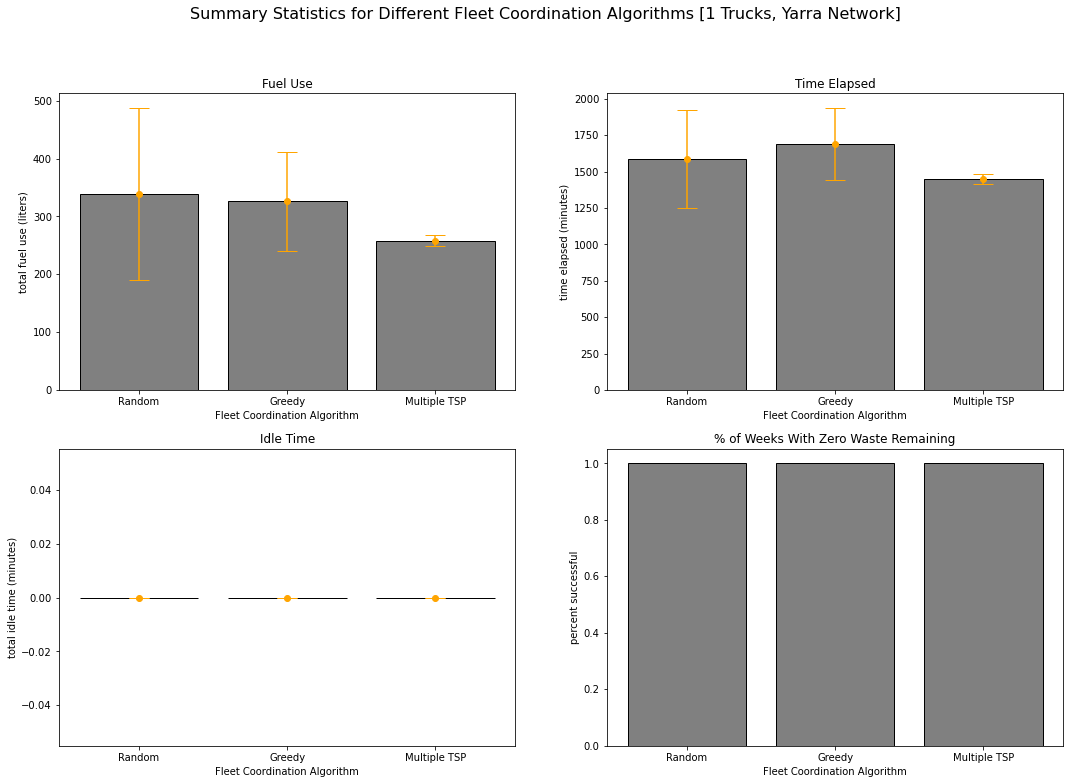

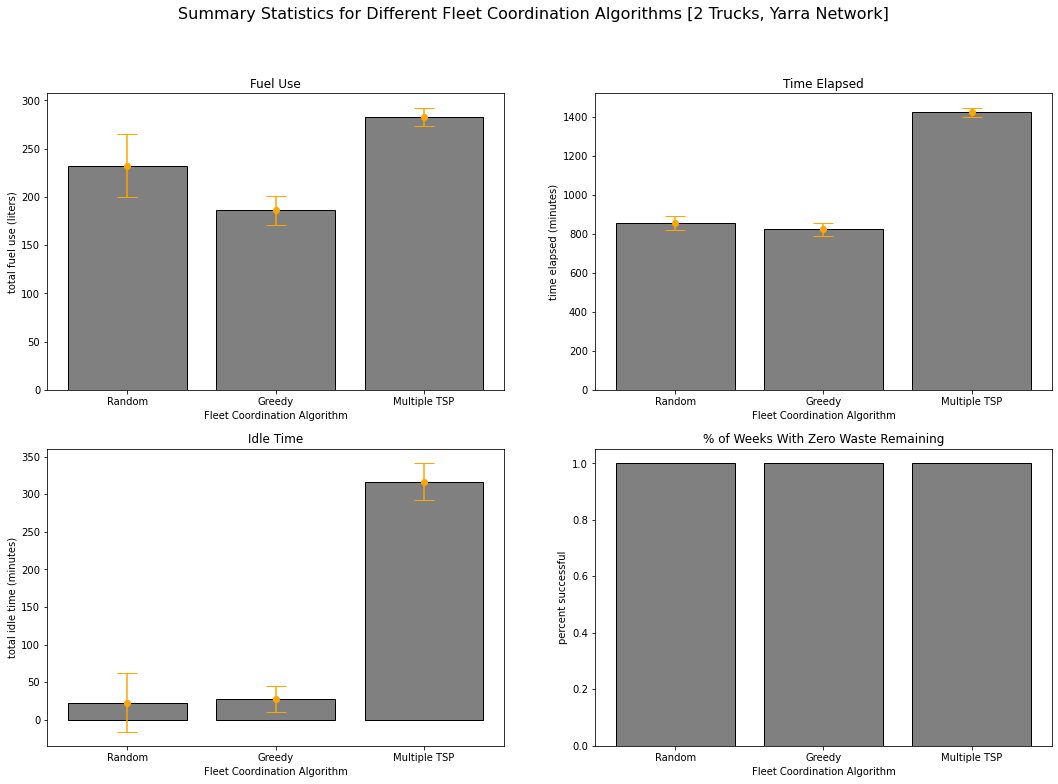

KeyboardInterrupt: 

In [114]:
generate_sim_viz(trials=5, num_trucks=1, network_type='yarra')
generate_sim_viz(trials=5, num_trucks=2, network_type='yarra')
generate_sim_viz(trials=5, num_trucks=3, network_type='yarra')

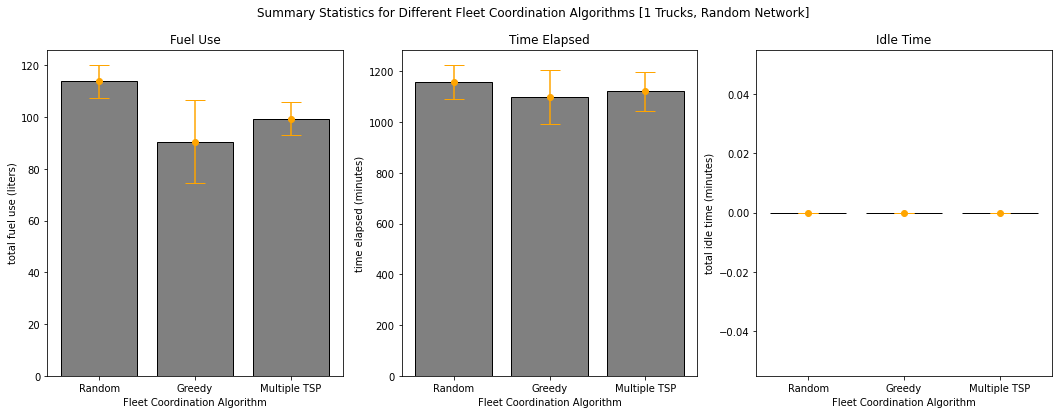

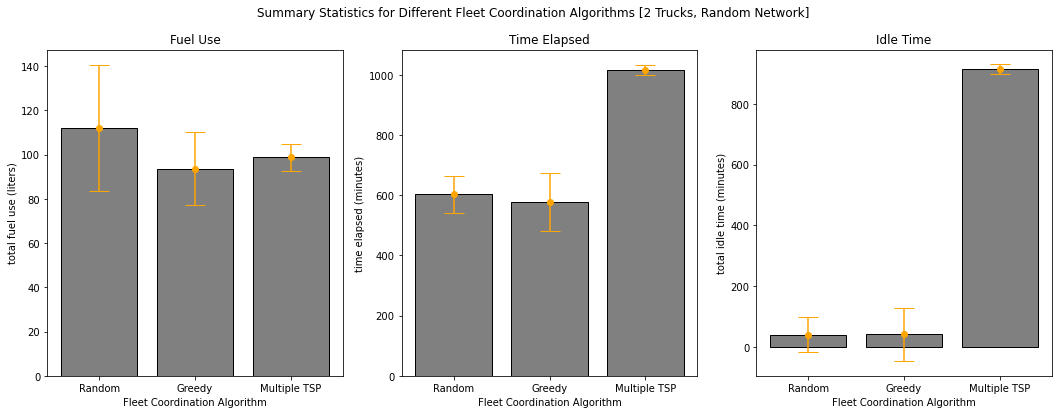

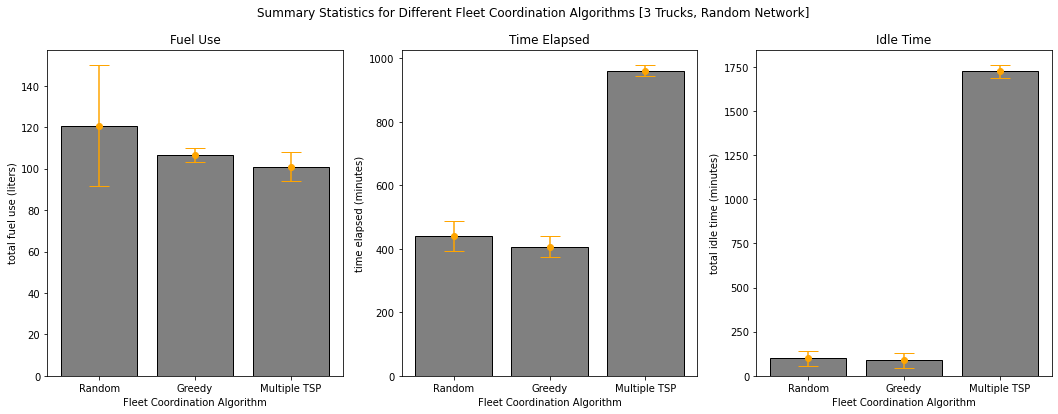

In [461]:
generate_sim_viz(trials=5, num_trucks=1, network_type='random')
generate_sim_viz(trials=5, num_trucks=2, network_type='random')
generate_sim_viz(trials=5, num_trucks=3, network_type='random')

## Experiments

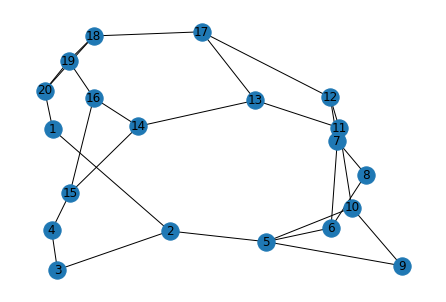

In [8]:
nx.draw(roads.network, with_labels=True)

In [9]:
def generate_tsp_path(network):
    distance_matrix = np.zeros((len(roads.network.nodes), len(roads.network.nodes)))
    for node, data in roads.network.nodes(data=True):
        for neighbor in list(roads.network.neighbors(node)):
            distance_matrix[node-1][neighbor-1] = roads.network[node][neighbor]['weight']
    
    distance_matrix[np.where(distance_matrix == 0)] = 100000

    # wineries = [node for node, data in roads.network.nodes(data=True) if data['node_type'] == 'winery']

    model = pyEnv.ConcreteModel()
    n = len(roads.network.nodes)
    model.M = pyEnv.RangeSet(n) # entering each city
    model.N = pyEnv.RangeSet(n) # leaving each city
    model.U = pyEnv.RangeSet(2,n)

    #Decision variables xij
    model.x=pyEnv.Var(model.N,model.M, within=pyEnv.Binary)

    #Dummy variable ui
    model.u=pyEnv.Var(model.N, within=pyEnv.NonNegativeIntegers,bounds=(0,n-1))

    model.c = pyEnv.Param(model.N, model.M,initialize=lambda model, i, j: distance_matrix[i-1][j-1])

    # minimize the
    def obj_func(model):
        return sum(model.x[i,j] * model.c[i,j] for i in model.N for j in model.M)

    model.objective = pyEnv.Objective(rule=obj_func,sense=pyEnv.minimize)

    def rule_const1(model,M):
        return sum(model.x[i,M] for i in model.N if i!=M) == 1

    model.const1 = pyEnv.Constraint(model.M,rule=rule_const1)

    def rule_const2(model,N):
        return sum(model.x[N,j] for j in model.M if j!=N) == 1

    model.rest2 = pyEnv.Constraint(model.N,rule=rule_const2)

    def rule_const3(model,i,j):
        if i!=j: 
            return model.u[i] - model.u[j] + model.x[i,j] * n <= n-1
        else:
            return model.u[i] - model.u[i] == 0 
        
    model.rest3 = pyEnv.Constraint(model.U,model.N,rule=rule_const3)

    solver = pyEnv.SolverFactory('glpk')
    result = solver.solve(model,tee = False)

    List = list(model.x.keys())
    tsp_edge_list = [i for i in List if model.x[i]() != 0]

    starting_edge = list(filter(lambda x: x[1] == 1, tsp_edge_list))[0]
    g = nx.from_edgelist(tsp_edge_list)
    g.remove_edge(*starting_edge)
    shortest_path = nx.shortest_path(g, starting_edge[1], starting_edge[0])

    return shortest_path
    

In [10]:
roads = WasteRoadNetwork()
roads.generate_yarra_valley_network()
generate_tsp_path(roads.network)

[1, 20, 19, 18, 17, 12, 7, 8, 6, 5, 9, 10, 11, 13, 14, 16, 15, 4, 3, 2]

# CVXPY VERSION

In [314]:
def generate_tsp_path(network):
    C = np.zeros((len(roads.network.nodes), len(roads.network.nodes)))
    for node, data in roads.network.nodes(data=True):
        for neighbor in list(roads.network.neighbors(node)):
            C[node-1][neighbor-1] = roads.network[node][neighbor]['weight']
    
    # wineries = [node for node, data in roads.network.nodes(data=True) if data['node_type'] == 'winery']
    C[np.where(C == 0)] = 100_000
    np.fill_diagonal(C, 0)
    n = len(network.nodes)

    C = C.astype(int)

    ################################################
    # Solving the integer programming problem
    ################################################

    # Defining the variables
    X = cp.Variable(C.shape, boolean=True)
    u = cp.Variable(n, integer=True)
    m = 3
    ones = np.ones((n,1))

    # Defining the objective function
    objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

    # Defining the constraints
    constraints = []
    constraints += [X[0,:] @ ones == m]
    constraints += [X[:,0] @ ones == m]
    constraints += [X[1:,:] @ ones == 1]
    constraints += [X[:,1:].T @ ones == 1]
    constraints += [cp.diag(X) == 0]
    constraints += [u[1:] >= 2]
    constraints += [u[1:] <= n]
    constraints += [u[0] == 1]

    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

    # Solving the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=False, solver='XPRESS')

    # Transforming the solution to paths
    X_sol = np.argwhere(X.value==1)
    print(prob.status)
    ruta = {}
    for i in range(0, m):
        ruta['Salesman_' + str(i+1)] = [0]
        j = i
        a = 10e10
        while a != 0:
            a = X_sol[j,1]
            ruta['Salesman_' + str(i+1)].append(a)
            j = np.where(X_sol[:,0] == a)
            j = j[0][0]
            a = j

    for i in ruta.keys():
        ruta[i] = [i+1 for i in ruta[i]]
    # Showing the paths
    for i in ruta.keys():
        print('The path of ' + i + ' is:\n')
        print( ' => '.join(map(str, ruta[i])))
        print('')
    print(ruta.values())

optimal
The path of Salesman_1 is:

1 => 7 => 8 => 6 => 5 => 9 => 10 => 11 => 12 => 17 => 18 => 19 => 20 => 14 => 2 => 3 => 4 => 15 => 1

The path of Salesman_2 is:

1 => 13 => 1

The path of Salesman_3 is:

1 => 16 => 1

dict_values([[1, 7, 8, 6, 5, 9, 10, 11, 12, 17, 18, 19, 20, 14, 2, 3, 4, 15, 1], [1, 13, 1], [1, 16, 1]])


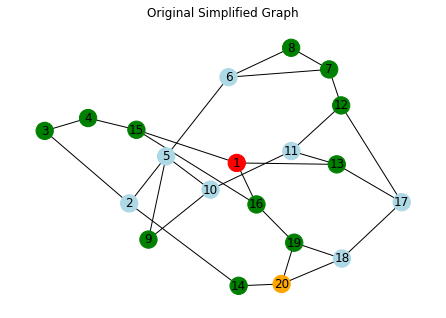

In [315]:
roads = WasteRoadNetwork()
roads.generate_yarra_valley_network()
paths = generate_tsp_path(roads.network)

nx.draw(roads.network, with_labels=True,
                node_color=[color_map[roads.network.nodes[i]['node_type']] for i in roads.network.nodes],
        )
plt.title("Original Simplified Graph")
plt.show()

# SIMPLIFIED GRAPH 

In [ ]:
def simplify_graph_with_predicate(G: nx.Graph, node_removal_predicate: callable):
            '''
            Loop over the graph until all nodes that match the supplied predicate 
            have been removed and their incident edges fused.
            '''
            g = G.copy()
            while any(node_removal_predicate(data) for node, data in g.nodes(data=True)):

                g0 = g.copy()

                for node, data in g.nodes(data=True):
                    if node_removal_predicate(data):
                        edges_containing_node = g.edges(node)
                        dst_to_link = [e[1] for e in edges_containing_node]
                        dst_pairs_to_link = list(combinations(dst_to_link, r = 2))
                        for pair in dst_pairs_to_link:
                           dist = nx.shortest_path_length(g0, pair[0], pair[1], weight='weight')
                           g0.add_edge(pair[0], pair[1], weight=dist)  
                        g0.remove_node(node)
                        break
                g = g0
            return g

        tsp_graph = simplify_graph_with_predicate(self.network, 
                                                 lambda x: x['node_type'] == 'intersection')

        def generate_tsp_path(input_network, num_trucks):
            color_map = {"office" :'red',  "dump": "orange", 'intersection':'lightblue', 'winery':'green'}

            nx.draw(input_network, with_labels=True,
                    node_color=[color_map[input_network.nodes[i]['node_type']] for i in input_network.nodes],
            )
            plt.title("Original Simplified Graph")
            plt.show()

            network_index_map = {sorted(list(input_network.nodes))[i]: i for i in range(len(input_network.nodes))}
            network_index_inverse_map = {j:i for i, j in network_index_map.items()}
            network = nx.relabel_nodes(input_network, network_index_map)

            nx.draw(network, with_labels=True,
                    node_color=[color_map[network.nodes[i]['node_type']] for i in network.nodes],
            )
            plt.title("Remapped Graph")
            plt.show()

            C = np.zeros((len(network.nodes), len(network.nodes)))
            for node, data in network.nodes(data=True):
                for neighbor in list(network.neighbors(node)):
                    C[node-1][neighbor-1] = network[node][neighbor]['weight']

            C[np.where(C == 0)] = 100
            np.fill_diagonal(C, 0)
            n = len(network.nodes)

            C = C.astype(int)
            
            n = len(network.nodes)

            X = cp.Variable(C.shape, boolean=True)
            u = cp.Variable(n, integer=True)
            m = 2
            ones = np.ones((n,1))

            # Defining the objective function
            objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

            # Defining the constraints
            constraints = []
            constraints += [X[0,:] @ ones == m]
            constraints += [X[:,0] @ ones == m]
            constraints += [X[1:,:] @ ones == 1]
            constraints += [X[:,1:].T @ ones == 1]
            constraints += [cp.diag(X) == 0]
            constraints += [u[1:] >= 2]
            constraints += [u[1:] <= n]
            constraints += [u[0] == 1]

            for i in range(1, n):
                for j in range(1, n):
                    if i != j:
                        constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

            # Solving the problem
            prob = cp.Problem(objective, constraints)
            prob.solve(verbose=False, solver="XPRESS")
            print("PROB_VALUE", prob.value)

            # Transforming the solution to paths
            X_sol = np.argwhere(X.value==1)

            routes = {}
            for i in range(0, m):
                routes['Truck' + str(i+1)] = [0]
                j = i
                a = 10e10
                while a != 0:
                    a = X_sol[j,1]
                    routes['Truck' + str(i+1)].append(a)
                    j = np.where(X_sol[:,0] == a)
                    j = j[0][0]
                    a = j
            updated_paths = []
            for path in routes.values():
                updated_paths.append([i for i in path])
                
            return dict(zip([f"Truck {i+1}" for i in range(num_trucks)], updated_paths))

        self.truck_paths = generate_tsp_path(tsp_graph, len(self.trucks))
